# 공식 문서 
## 커스텀 state

In [1]:
import getpass
import os

#환경변수에 값 등록하기 위한 함수
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [2]:
# Tavily_api_key 입력 
_set_env("TAVILY_API_KEY")

#openai api key 저장. 입력시 실수하지 않도록 주의할 것. 
_set_env("OPENAI_API_KEY")

#Anthropic api key 입력 #이건 필요한 경우만. 
# _set_env("ANTHROPIC_API_KEY")

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# 초기 스테이트 정의. 
class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [ ]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt

# 상태 업데이트를 위해 tool message를 생성하여 일반적으로 해당 도구 호출의 id가 필요
# LangChain의 InjustedToolCallId를 사용하여 도구 호출을 위한 id 부여 
# 또한 api 스키마에 노출되지 않음.(LLM에 전달 x, langchain에서만 관리.)
@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
    ) -> str:
    """ Request assistance from a human.  """ # langgraph에서 tool에 등록하기 위한 문서 설명. 삭제할 경우 코드 정지하니 절대로 삭제하지 말것.!!!!!!
    #정지 요청. human_response = command()를 통해 명령 입력
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # 정보에 문제가 없으면 그대로 사용. .
    if human_response.get("correct", "").lower().startswith("y"): #correct키의 값이 y로 시작하는지 확인. 
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # 아닐 경우 인간 검토자로부터 정보를 획득. 
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [5]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# 챗봇 형성용 코드 
tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm  = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
tool_node = ToolNode(tools=tools)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

#conditional edge 선언. chatbot와 tools_contitions연결
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot") #tools와 chatbot 연결. 
graph_builder.add_edge(START, "chatbot") #start와 chatbot 연결. 

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

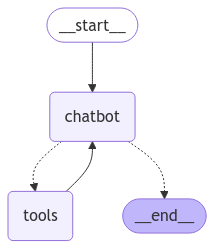

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
user_input = (
    "langgraph가 언제 개발되었는지 보여줄 수 있어? "
    "답이 있는 경우, 검토를 위해 human_assistance 도구를 사용해"
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

# 현재 상황에서는 birthday를 랜덤으로 반환하게 됨. 

================================ Human Message =================================

langgraph가 언제 개발되었는지 보여줄 수 있어? 답이 있는 경우, 검토를 위해 human_assistance 도구를 사용해
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_QfwKj0D51RJWjew6ia2La5A3)
 Call ID: call_QfwKj0D51RJWjew6ia2La5A3
  Args:
    query: langgraph 개발 연도
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://cloud.google.com/vertex-ai/generative-ai/docs/reasoning-engine/develop-langgraph?hl=ko", "content": "컴퓨팅 데이터베이스 아키텍처 센터 中文 – 简体 무료로 시작하기 컴퓨팅 데이터베이스 아키텍처 센터 # top_k (int): The next token is selected from among the top-k most 먼저 generate_models 패키지를 가져오고 도구를 만듭니다. This eclipse will be visible from three states: Montana, North Dakota, and * The Matrix (1999): A computer hacker learns from mysterious rebels about the true nature of his reality and his role in the war against its con

In [8]:
#correct만 활성화 시키면 기존 정보가 맞다고 인식시켜 기존 검색결과를 사용. 
human_command = Command(
    resume={
        # "correct" : "yes"
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_zIly4KO21wbaRFyIROesCi7F)
 Call ID: call_zIly4KO21wbaRFyIROesCi7F
  Args:
    name: langgraph
    birthday: not applicable
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph는 2024년 1월 17일에 개발되었습니다.


In [9]:
#graph에서 config 조건에서 state를 획득하여snapshot에 할당. 
snapshot = graph.get_state(config)
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")} #name와 birthday 키에 대한 값을 출력. 

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

In [10]:
#state 값을 수동으로 갱신하는 방법.
# config를 이용해 수정할 state를 선택. name :  LangGraph -> 'name': 'LangGraph (library)
graph.update_state(config, {"name": "LangGraph (library)"})

#graph에서 config 조건에서 state를 획득하여snapshot에 할당. 
snapshot = graph.get_state(config)
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")} #name와 birthday 키에 대한 값을 출력. 

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

### 아래 코드는 챗봇을 구성하기 위한 코드를 하나의 셀로 합쳐 놓은 셀임. 기능은 위에서 사용한 코드와 동일함. 

In [14]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str


@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    return Command(update=state_update)

tool = TavilySearchResults(max_results=2)

tools = [tool, human_assistance]
llm  = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}
tool_node = ToolNode(tools=tools)


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)